# GAN

 



## 1-1 GAN이란?

### 1-1 Vanilla GAN

In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models
from tqdm.notebook import tqdm #진행도 확인하는 함수

학습이 된 Gan모델에 노이즈값을 넣은 뒤 예측한 이미지를 보여주는 함수입니다.

In [ ]:
def plot_generated_images(epoch, generator):
    noise= np.random.normal(0, 1, [100, 100]) #100개의 노이즈 값을 생성합니다.
    make_images = generator.predict(noise) # 노이즈값을 통해서 GAN으로 이미지 생성합니다.
    make_images = make_images.reshape(100,28,28) # Mnist 사이즈와 동일하게 바꿔줍니다.
    plt.figure(figsize=(10,10)) # 이미지 크기 지정
    for i in range(make_images.shape[0]): #이미지 갯수 100만큼 반복
        plt.subplot(10, 10, i+1) #바둑판식으로 표현
        plt.imshow(make_images[i],plt.get_cmap('gray'))
        plt.axis('off')
    plt.tight_layout()

Compile에서 Adam optmizer를 호출이 가능하지만 세부조정이 어렵습니다. 
이번에는 Adam optimizer를 생성하는 함수를 만들었습니다.  
lr이라는 부분이 규제를 넣는 부분이고, beta_1, beta_2등 여러 규제를 넣을 수 가 있습니다. 

In [ ]:
def adam_optimizer() : 
  return tf.keras.optimizers.Adam(0.001) # w <- w - a*G : a = learning_rate = 0.001

Vanilla GAN 모델링에 관한 코드입니다.  
GAN은 2개의 모델이 필수적으로 사용을 하게 됩니다.  

실제이미지와 가짜 이미지를 판별해주는 Discriminator  
가짜이미지를 생성하는 Generator 모델입니다.   
모델마다 각자의 optimizer를 갖고 있으며 --> 충돌을 방지를 합니다.

데이터는 Fashion Mnist데이터를 이용하여 실습하겠습니다.

In [ ]:
epochs = 20  #반복 횟수를 정해줍니다.
batch_size = 128 #배치사이즈를 정해줍니다.

(x_train, _), (_, _) = datasets.fashion_mnist.load_data() 
x_train = (x_train.astype(np.float32)-127.5)/127.5  
x_train = x_train.reshape(60000, 784) 
batch_count = x_train.shape[0] / batch_size  #데이터의 양을 배치사이즈 크기만큼 나눠서 학습시킵니다.

4423680/4422102 [==============================] - 0s 0us/step


Generator 모델을 만듭니다.  
입력데이터는 100개의 노이즈 이며 3층으로 쌓은 FFN 입니다.  
활성함수는 ReLU를 사용하였고, 마지막에는 Tanh를 사용하였습니다.  

Binary_crossetropy를 사용하여 이진 분류를 사용하였고, optimizer는 아까 규제를 넣은 adam을 사용하였습니다. 
  
Dropout을 사용하게 되었습니다. 

Generator의 최종 결과는 784이고 이는 mnist의 이미지 크기와 동일합니다.


In [ ]:
generator=models.Sequential()
generator.add(layers.Dense(256,input_dim=100,activation='relu'))
generator.add(layers.Dense(512,activation='relu'))
generator.add(layers.Dropout(0.3))
generator.add(layers.Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

discriminator 모델을 만듭니다. 
입력데이터는 minist파일의 크기이며 3층으로 쌓은 FFN 모델입니다.  
Generator와 다르게 unit의 수가 점점 줄어드는 것을 확인 할 수 있습니다.  

마지막 활성함수는 sigmoid를 사용함으로서 0 1사이에 거짓 이미지인지 실제 이미지인지를 판별을 해주는 것입니다.  

In [ ]:
discriminator=models.Sequential()
discriminator.add(layers.Dense(512,input_dim=784, activation='relu'))
discriminator.add(layers.Dense(256,activation='relu'))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())

이제는 두 모델을 합칩니다.  
discriminator.trainable=Fals --> 학습을 하지만 weight값을 변경을 못하게 하는 의미를 가집니다.  
실제이미지와 가짜이미지를 판결하기 위해서 Binary_CrossEntropy를 사용하였고,  
input의 데이터는 가짜이미지이고, output은 실제인지 가짜인지 판별해주는 discriminator의 결과값입니다.  

In [ ]:
discriminator.trainable=False # weight 학습불가
gan_input = layers.Input(shape=(100,))
x = generator(gan_input)
gan_output= discriminator(x)
gan= models.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

모델을 학습시키는 코드입니다. 

위에서 설정한 Epochs 수만큼 학습을 하게 되고, batch_count만큼 반복하게 됩니다.     
x_train[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]의 코드는 

데이터의 0 ~ 데이터의 크기 중 batch_size만큼 랜덤으로 뽑는 것입니다.   
진짜 이미지와 가짜 이미지를 합친 후  
그 크기만큼의 배열을 생성한 뒤 실제 이미지에는 0.9의 값을 주고 가짜 이미지에는 0의 값을 줍니다.  
그 후 discriminator를 학습을 시킵니다.  
배치사이즈 크기만큼 배열을 생성한 뒤 값을 1로 세팅하여 gan에 노이즈값과 함께 학습을 시킵니다. 

In [ ]:
 x_train.shape[0]

60000

Epochs :  1
Epochs :  2
Epochs :  3
Epochs :  4
Epochs :  5
Epochs :  6
Epochs :  7
Epochs :  8
Epochs :  9
Epochs :  10
Epochs :  11
Epochs :  12
Epochs :  13
Epochs :  14
Epochs :  15
Epochs :  16
Epochs :  17
Epochs :  18
Epochs :  19
Epochs :  20


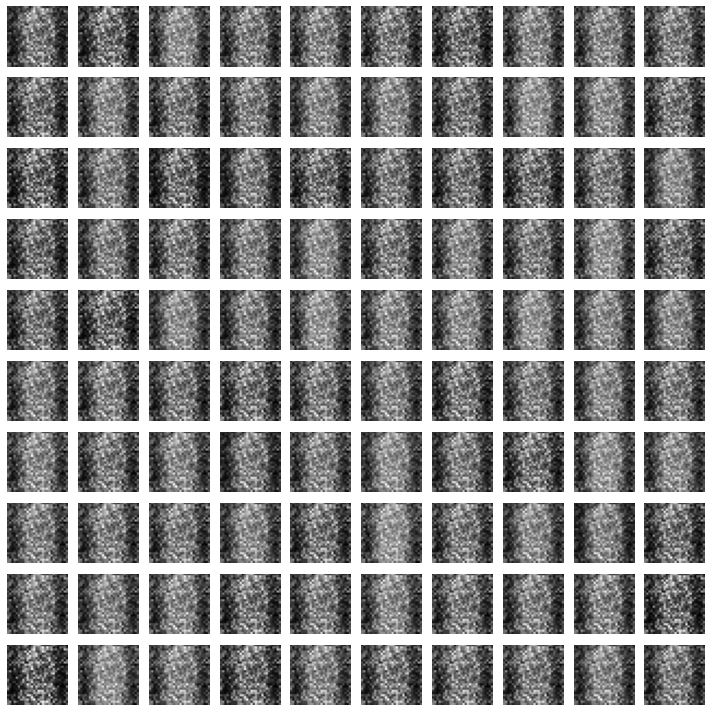

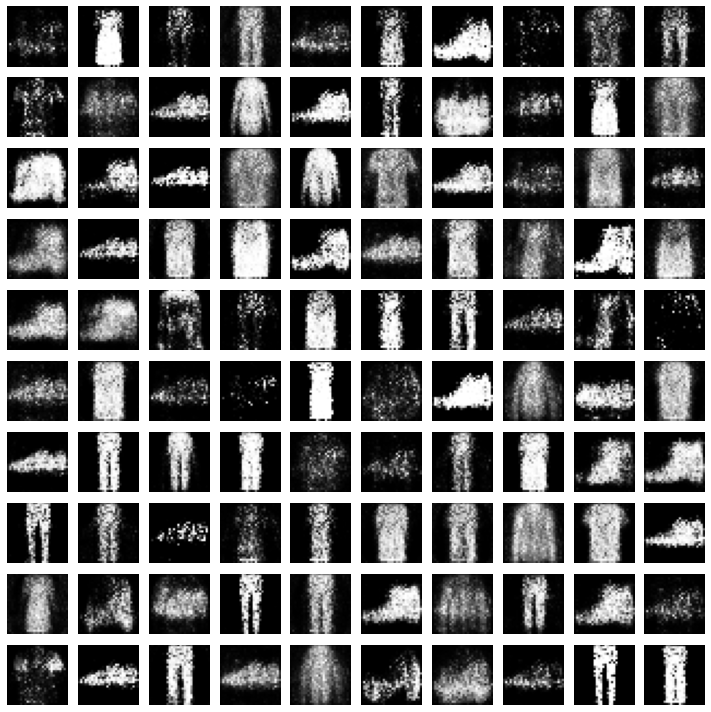

In [ ]:
for Epochs in range(1,epochs+1):
    print("Epochs : ",Epochs)
    for _ in range(int(batch_count)):
        noise = np.random.normal(0,1, [batch_size, 100]) #노이즈값 생성
        generated_images = generator.predict(noise) #노이즈 값으로 이미지 예측
        image_batch =x_train[np.random.randint(0,x_train.shape[0],batch_size)]
        X= np.concatenate([image_batch, generated_images])
        y_dis=np.zeros(2*batch_size)
        y_dis[:batch_size]=0.9 #라벨 스무딩

        #training
        discriminator.train_on_batch(X, y_dis)

        y_gen = np.ones(batch_size)
        gan.train_on_batch(noise, y_gen) # input -> generator -> discriminator.trainable=F 

    if Epochs == 1 or Epochs % 20 == 0: #20번 마다 이미지 출력
        plot_generated_images(Epochs, generator)